In [1]:
!python -V

Python 3.13.2


In [2]:
import pandas as pd

In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [6]:
import mlflow

mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("my_scnd_experiment")


2025/05/19 18:59:02 INFO mlflow.tracking.fluent: Experiment with name 'my_scnd_experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1747673941998, experiment_id='1', last_update_time=1747673941998, lifecycle_stage='active', name='my_scnd_experiment', tags={}>

In [7]:
print("Tracking URI:", mlflow.get_tracking_uri())


Tracking URI: http://127.0.0.1:5000


In [8]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')

In [9]:
df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)

In [10]:
df['duration'] =df.lpep_dropoff_datetime - df.lpep_pickup_datetime

In [11]:
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60) #convert to minutes

In [12]:
df=df[df.trip_type == 2] #Dispatch

In [13]:
df.duration.describe(percentiles=[0.95,0.98,0.99])

count    1238.000000
mean       18.305493
std       108.364382
min         0.000000
50%         1.666667
95%        35.604167
98%        59.339333
99%       149.837833
max      1416.100000
Name: duration, dtype: float64

In [14]:
((df.duration >= 1) & (df.duration <= 60)).mean()

np.float64(0.5169628432956381)

In [15]:
df = df[((df.duration >= 1) & (df.duration <= 60))]

In [16]:
categorical = ['PULocationID','DOLocationID']
numerical = ['trip_distance']

In [17]:
df[categorical] = df[categorical].astype(str)

In [18]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
30,2,2021-01-01 00:35:29,2021-01-01 00:55:15,N,5.0,74,247,1.0,3.64,13.0,...,0.0,0.0,0.0,None,0.3,13.3,2.0,2.0,0.0,19.766667
53,2,2021-01-01 01:54:51,2021-01-01 02:15:35,N,5.0,74,94,1.0,5.82,18.0,...,0.0,0.0,0.0,None,0.3,18.3,2.0,2.0,0.0,20.733333
69,2,2021-01-01 02:42:49,2021-01-01 02:50:59,N,5.0,136,241,1.0,0.57,9.0,...,0.0,0.0,0.0,None,0.3,9.3,2.0,2.0,0.0,8.166667
88,2,2021-01-01 04:52:02,2021-01-01 05:05:01,N,5.0,247,75,1.0,3.43,15.0,...,0.0,0.0,0.0,None,0.3,15.3,2.0,2.0,0.0,12.983333
96,2,2021-01-01 05:52:43,2021-01-01 05:58:02,N,5.0,7,7,1.0,0.65,50.0,...,0.0,7.0,0.0,None,0.3,57.3,1.0,2.0,0.0,5.316667


In [19]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

In [20]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [21]:
X_train

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1920 stored elements and shape (640, 236)>

In [22]:
dv.feature_names_

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=106',
 'DOLocationID=107',
 'DOLocationID=112',
 'DOLocationID=116',
 'DOLocationID=118',
 'DOLocationID=119',
 'DOLocationID=121',
 'DOLocationID=126',
 'DOLocationID=127',
 'DOLocationID=128',
 'DOLocationID=129',
 'DOLocationID=130',
 'DOLocationID=131',
 'DOLocationID=132',
 'DOLocationID=134',
 'DOLocationID=135',
 'DOLocationID=136',
 'DOLocationID=138',
 'DOLocationID=140',
 'DOLocationID=141',
 'DOLocationID=143',
 'DOLocationID=145',
 'DOLocationID=146',
 'DOLocationID=147',
 'DOLocationID=148',
 'DOLocationID=151',
 'DOLocationID=152',
 'DOLocationID=156',
 'DOLocationID=159',
 'DOLocationID=16',
 'DOLocationID=161',
 'DOLocationID=162',
 'DOLocationID=163',
 'DOLocationID=165',
 'DOLocationID=166',
 'DOLocationID=167',
 'DOLocationID=168',
 'DOLocationID=169',
 'DOLocationID=17',
 'DOLocationID=170',
 'DOLocationID=173',
 'DOLocationID=174',
 'DOLocationID=177',
 'DOLocationID=179',
 'DOLocationID=18',
 'DOLocationID=182'

In [23]:
target = 'duration'
y_train = df[target].values

In [24]:
y_train

array([19.76666667, 20.73333333,  8.16666667, 12.98333333,  5.31666667,
        1.26666667,  1.6       ,  5.03333333,  1.86666667,  6.38333333,
       34.71666667,  1.35      , 27.23333333,  9.11666667, 26.23333333,
       28.75      , 22.01666667, 21.85      , 20.96666667, 21.61666667,
        9.26666667, 22.63333333, 25.41666667,  1.2       , 16.7       ,
       49.2       ,  7.35      , 14.16666667, 13.58333333, 24.06666667,
       24.2       , 27.21666667, 19.61666667, 12.71666667, 18.83333333,
        6.26666667,  2.53333333, 13.26666667,  7.63333333, 54.71666667,
        3.75      ,  4.15      ,  3.65      , 10.26666667,  5.6       ,
        2.93333333, 33.95      ,  6.53333333, 10.08333333, 21.96666667,
       30.96666667,  5.78333333, 11.05      ,  7.35      , 18.15      ,
       10.25      ,  1.95      ,  1.95      , 38.2       , 12.3       ,
       14.03333333, 16.91666667,  3.83333333, 14.31666667,  7.01666667,
       19.56666667,  6.41666667, 38.48333333, 34.98333333, 10.38

In [25]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [26]:
y_pred = lr.predict(X_train)

C:\Users\Christian\AppData\Local\Temp\ipykernel_12716\3882591490.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
C:\Users\Christian\AppData\Local\Temp\ipykernel_12716\3882591490.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train,label='actual')


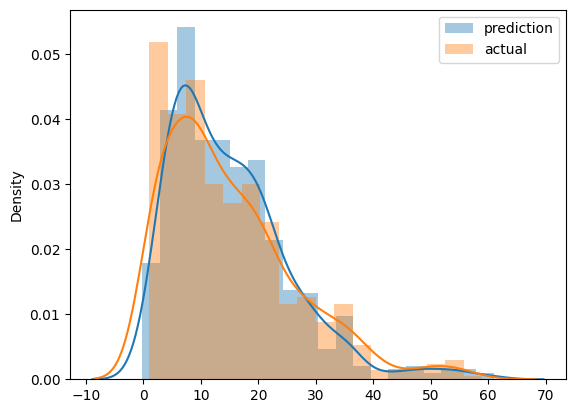

In [27]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train,label='actual')
plt.legend()

In [28]:
import math
rmse = mean_squared_error(y_train, y_pred)
math.sqrt(rmse)

4.803126149499836

In [29]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    
    df['duration'] =df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds()  / 60)
    
    df = df[((df.duration >= 1) & (df.duration <= 60))]
    
    categorical = ['PULocationID','DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [30]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')

In [31]:
len(df_train), len(df_val)

(73908, 61921)

In [32]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [33]:
df_val

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration,PU_DO
0,2,2021-02-01 00:34:03,2021-02-01 00:51:58,N,1.0,130,205,5.0,3.66,14.00,...,10.00,0.0,None,0.3,25.30,1.0,1.0,0.00,17.916667,130_205
1,2,2021-02-01 00:04:00,2021-02-01 00:10:30,N,1.0,152,244,1.0,1.10,6.50,...,0.00,0.0,None,0.3,7.80,2.0,1.0,0.00,6.500000,152_244
2,2,2021-02-01 00:18:51,2021-02-01 00:34:06,N,1.0,152,48,1.0,4.93,16.50,...,0.00,0.0,None,0.3,20.55,2.0,1.0,2.75,15.250000,152_48
3,2,2021-02-01 00:53:27,2021-02-01 01:11:41,N,1.0,152,241,1.0,6.70,21.00,...,0.00,0.0,None,0.3,22.30,2.0,1.0,0.00,18.233333,152_241
4,2,2021-02-01 00:57:46,2021-02-01 01:06:44,N,1.0,75,42,1.0,1.89,8.50,...,2.45,0.0,None,0.3,12.25,1.0,1.0,0.00,8.966667,75_42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64567,2,2021-02-28 22:19:00,2021-02-28 22:29:00,None,NaN,129,7,NaN,2.63,10.04,...,0.00,0.0,None,0.3,10.34,NaN,NaN,NaN,10.000000,129_7
64568,2,2021-02-28 23:18:00,2021-02-28 23:27:00,None,NaN,116,166,NaN,1.87,8.33,...,1.89,0.0,None,0.3,10.52,NaN,NaN,NaN,9.000000,116_166
64569,2,2021-02-28 23:44:00,2021-02-28 23:58:00,None,NaN,74,151,NaN,2.40,12.61,...,0.00,0.0,None,0.3,12.91,NaN,NaN,NaN,14.000000,74_151
64570,2,2021-02-28 23:07:00,2021-02-28 23:14:00,None,NaN,42,42,NaN,1.11,11.95,...,0.00,0.0,None,0.3,15.00,NaN,NaN,NaN,7.000000,42_42


In [34]:
categorical = ['PU_DO']#'PULocationID','DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)


In [35]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [36]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)

rmse = mean_squared_error(y_val,y_pred)
math.sqrt(rmse)

7.758715202840848

In [ ]:
with mlflow.start_run():
    mlflow.set_tag("developer","christian")
    mlflow.log_param("train-data-path","./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path","./data/green_tripdata_2021-02.parquet")
    alpha = 0.001
    mlflow.log_param("alpha",alpha)
    lr = Lasso(alpha)   
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val,y_pred)
    math.sqrt(rmse)
    mlflow.log_metric("rmse",math.sqrt(rmse))

🏃 View run lyrical-toad-46 at: http://127.0.0.1:5000/#/experiments/1/runs/a578326cff084c10b17bdc365e5acb12
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [38]:
with mlflow.start_run():
    mlflow.set_tag("developer","christian")
    mlflow.log_param("train-data-path","./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path","./data/green_tripdata_2021-02.parquet")
    alpha = 0.1
    mlflow.log_param("alpha",alpha)
    lr = Lasso(alpha)   
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val,y_pred)
    math.sqrt(rmse)
    mlflow.log_metric("rmse",math.sqrt(rmse))

🏃 View run adventurous-loon-498 at: http://127.0.0.1:5000/#/experiments/1/runs/e284fd6d995b478e8ee02675e9b369fd
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [ ]:
!pip install xgboost

In [56]:
!pip install hyperopt

In [ ]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope


In [52]:
train = xgb.DMatrix(X_train,label=y_train)
valid = xgb.DMatrix(X_val,label=y_val)

In [54]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model","xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid,"validation")],
            early_stopping_rounds = 50
        )
        y_pred = booster.predict(valid)
        rmse = math.sqrt(mean_squared_error(y_val,y_pred))
        mlflow.log_metric("rmse",rmse)
    return {'loss': rmse, 'status': STATUS_OK}

In [57]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth',4,100,1)),
    'learning_rate': hp.loguniform('learning_rate',-3,0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight',-1,3),
    'objective': 'reg:linear',
    'seed': 42
}
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [19:48:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:7.32158                           
[1]	validation-rmse:6.77537                           
[2]	validation-rmse:6.68773                           
[3]	validation-rmse:6.67082                           
[4]	validation-rmse:6.65128                           
[5]	validation-rmse:6.64347                           
[6]	validation-rmse:6.63292                           
[7]	validation-rmse:6.62536                           
[8]	validation-rmse:6.62053                           
[9]	validation-rmse:6.61643                           
[10]	validation-rmse:6.60798                          
[11]	validation-rmse:6.60546                          
[12]	validation-rmse:6.60066                          
[13]	validation-rmse:6.59786                          
[14]	validation-rmse:6.59384                          
[15]	validation-rmse:6.59072                          
[16]	validation-rmse:6.58690                          
[17]	validation-rmse:6.58283                          
[18]	valid

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [19:48:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.86151                                                   
[1]	validation-rmse:9.81650                                                    
[2]	validation-rmse:9.01622                                                    
[3]	validation-rmse:8.40586                                                    
[4]	validation-rmse:7.94782                                                    
[5]	validation-rmse:7.59807                                                    
[6]	validation-rmse:7.34673                                                    
[7]	validation-rmse:7.15998                                                    
[8]	validation-rmse:7.01903                                                    
[9]	validation-rmse:6.91374                                                    
[10]	validation-rmse:6.83453                                                   
[11]	validation-rmse:6.77477                                                   
[12]	validation-rmse:6.72505            

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [19:49:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.79743                                                   
[1]	validation-rmse:11.40918                                                   
[2]	validation-rmse:11.04711                                                   
[3]	validation-rmse:10.70938                                                   
[4]	validation-rmse:10.39475                                                   
[5]	validation-rmse:10.10204                                                   
[6]	validation-rmse:9.83048                                                    
[7]	validation-rmse:9.57831                                                    
[8]	validation-rmse:9.34410                                                    
[9]	validation-rmse:9.12715                                                    
[10]	validation-rmse:8.92605                                                   
[11]	validation-rmse:8.73994                                                   
[12]	validation-rmse:8.56750            

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [19:50:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:9.88173                                                    
[1]	validation-rmse:8.46965                                                    
[2]	validation-rmse:7.64000                                                    
[3]	validation-rmse:7.16974                                                    
[4]	validation-rmse:6.90379                                                    
[5]	validation-rmse:6.75163                                                    
[6]	validation-rmse:6.66058                                                    
[7]	validation-rmse:6.60381                                                    
[8]	validation-rmse:6.56732                                                    
[9]	validation-rmse:6.54313                                                    
[10]	validation-rmse:6.52565                                                   
[11]	validation-rmse:6.51395                                                   
[12]	validation-rmse:6.50409            

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [19:50:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.58956                                                   
[1]	validation-rmse:9.40394                                                    
[2]	validation-rmse:8.55192                                                    
[3]	validation-rmse:7.95172                                                    
[4]	validation-rmse:7.53398                                                    
[5]	validation-rmse:7.24056                                                    
[6]	validation-rmse:7.03868                                                    
[7]	validation-rmse:6.89781                                                    
[8]	validation-rmse:6.79889                                                    
[9]	validation-rmse:6.72679                                                    
[10]	validation-rmse:6.67407                                                   
[11]	validation-rmse:6.63457                                                   
[12]	validation-rmse:6.60499            

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [19:51:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:6.73989                                                    
[1]	validation-rmse:6.62701                                                    
[2]	validation-rmse:6.61057                                                    
[3]	validation-rmse:6.60644                                                    
[4]	validation-rmse:6.59683                                                    
[5]	validation-rmse:6.58919                                                    
[6]	validation-rmse:6.58349                                                    
[7]	validation-rmse:6.57567                                                    
[8]	validation-rmse:6.56765                                                    
[9]	validation-rmse:6.55511                                                    
[10]	validation-rmse:6.54629                                                   
[11]	validation-rmse:6.54320                                                   
[12]	validation-rmse:6.53887            

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [19:51:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.63830                                                    
[1]	validation-rmse:7.34521                                                    
[2]	validation-rmse:6.90825                                                    
[3]	validation-rmse:6.75330                                                    
[4]	validation-rmse:6.69321                                                    
[5]	validation-rmse:6.66169                                                    
[6]	validation-rmse:6.64710                                                    
[7]	validation-rmse:6.63437                                                    
[8]	validation-rmse:6.62997                                                    
[9]	validation-rmse:6.62672                                                    
[10]	validation-rmse:6.61880                                                   
[11]	validation-rmse:6.61399                                                   
[12]	validation-rmse:6.61111            

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [19:51:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[8]	validation-rmse:8.14135                                                    
[9]	validation-rmse:7.94039                                                    
[10]	validation-rmse:7.76772                                                   
[11]	validation-rmse:7.62141                                                   
[12]	validation-rmse:7.49619                                                   
[13]	validation-rmse:7.39022                                                   
[14]	validation-rmse:7.29930                                                   
[15]	validation-rmse:7.22187                                                   
[16]	validation-rmse:7.15552                                                   
[17]	validation-rmse:7.09997                                                   
[18]	validation-rmse:7.05091                                                   
[19]	validation-rmse:7.01018                                                   
[20]	validation-rmse:6.97368            

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [19:51:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.76498                                                   
[1]	validation-rmse:11.34905                                                   
[2]	validation-rmse:10.96365                                                   
[3]	validation-rmse:10.60656                                                   
[4]	validation-rmse:10.27670                                                   
[5]	validation-rmse:9.97137                                                    
[6]	validation-rmse:9.69011                                                    
[7]	validation-rmse:9.43044                                                    
[8]	validation-rmse:9.19147                                                    
[9]	validation-rmse:8.97183                                                    
[10]	validation-rmse:8.76932                                                   
[11]	validation-rmse:8.58271                                                   
[12]	validation-rmse:8.41215            

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [19:52:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:7.82116                                                    
[1]	validation-rmse:6.97009                                                    
[2]	validation-rmse:6.80100                                                    
[3]	validation-rmse:6.73576                                                    
[4]	validation-rmse:6.70543                                                    
[5]	validation-rmse:6.69062                                                    
[6]	validation-rmse:6.68505                                                    
[7]	validation-rmse:6.68243                                                    
[8]	validation-rmse:6.67946                                                    
[9]	validation-rmse:6.67893                                                    
[10]	validation-rmse:6.67582                                                   
[11]	validation-rmse:6.67528                                                   
[12]	validation-rmse:6.67555            

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [19:52:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.47215                                                    
[1]	validation-rmse:10.81802                                                    
[2]	validation-rmse:10.24296                                                    
[3]	validation-rmse:9.73810                                                     
[4]	validation-rmse:9.29754                                                     
[5]	validation-rmse:8.91395                                                     
[6]	validation-rmse:8.58085                                                     
[7]	validation-rmse:8.29205                                                     
[8]	validation-rmse:8.04259                                                     
[9]	validation-rmse:7.82768                                                     
[10]	validation-rmse:7.64308                                                    
[11]	validation-rmse:7.48557                                                    
[12]	validation-rmse:7.34988

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [19:55:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.01514                                                     
[1]	validation-rmse:6.95807                                                     
[2]	validation-rmse:6.69969                                                     
[3]	validation-rmse:6.62269                                                     
[4]	validation-rmse:6.59216                                                     
[5]	validation-rmse:6.57793                                                     
[6]	validation-rmse:6.57097                                                     
[7]	validation-rmse:6.56268                                                     
[8]	validation-rmse:6.55740                                                     
[9]	validation-rmse:6.55040                                                     
[10]	validation-rmse:6.54400                                                    
[11]	validation-rmse:6.53608                                                    
[12]	validation-rmse:6.53142

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [19:55:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.53359                                                     
[1]	validation-rmse:7.26244                                                     
[2]	validation-rmse:6.84074                                                     
[3]	validation-rmse:6.67958                                                     
[4]	validation-rmse:6.61364                                                     
[5]	validation-rmse:6.58463                                                     
[6]	validation-rmse:6.56549                                                     
[7]	validation-rmse:6.55245                                                     
[8]	validation-rmse:6.54737                                                     
[9]	validation-rmse:6.54271                                                     
[10]	validation-rmse:6.53723                                                    
[11]	validation-rmse:6.53341                                                    
[12]	validation-rmse:6.53126

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [19:56:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.79120                                                    
[1]	validation-rmse:11.39783                                                    
[2]	validation-rmse:11.03129                                                    
[3]	validation-rmse:10.69008                                                    
[4]	validation-rmse:10.37287                                                    
[5]	validation-rmse:10.07819                                                    
[6]	validation-rmse:9.80507                                                     
[7]	validation-rmse:9.55188                                                     
[8]	validation-rmse:9.31756                                                     
[9]	validation-rmse:9.10047                                                     
[10]	validation-rmse:8.89998                                                    
[11]	validation-rmse:8.71488                                                    
[12]	validation-rmse:8.54450

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [19:56:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.55708                                                    
[1]	validation-rmse:10.97091                                                    
[2]	validation-rmse:10.44883                                                    
[3]	validation-rmse:9.98479                                                     
[4]	validation-rmse:9.57334                                                     
[5]	validation-rmse:9.21003                                                     
[6]	validation-rmse:8.88917                                                     
[7]	validation-rmse:8.60665                                                     
[8]	validation-rmse:8.35937                                                     
[9]	validation-rmse:8.14261                                                     
[10]	validation-rmse:7.95310                                                    
[11]	validation-rmse:7.78797                                                    
[12]	validation-rmse:7.64373

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [19:57:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.97215                                                    
[1]	validation-rmse:9.98631                                                     
[2]	validation-rmse:9.21110                                                     
[3]	validation-rmse:8.60731                                                     
[4]	validation-rmse:8.14274                                                     
[5]	validation-rmse:7.78517                                                     
[6]	validation-rmse:7.51454                                                     
[7]	validation-rmse:7.31005                                                     
[8]	validation-rmse:7.15385                                                     
[9]	validation-rmse:7.03492                                                     
[10]	validation-rmse:6.93998                                                    
[11]	validation-rmse:6.86676                                                    
[12]	validation-rmse:6.81317

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [19:58:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.70146                                                    
[1]	validation-rmse:11.23351                                                    
[2]	validation-rmse:10.80444                                                    
[3]	validation-rmse:10.41193                                                    
[4]	validation-rmse:10.05274                                                    
[5]	validation-rmse:9.72210                                                     
[6]	validation-rmse:9.42519                                                     
[7]	validation-rmse:9.15184                                                     
[8]	validation-rmse:8.90548                                                     
[9]	validation-rmse:8.68013                                                     
[10]	validation-rmse:8.47404                                                    
[11]	validation-rmse:8.29018                                                    
[12]	validation-rmse:8.12184

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [20:00:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:9.60975                                                     
[2]	validation-rmse:8.78964                                                     
[3]	validation-rmse:8.19788                                                     
[4]	validation-rmse:7.77134                                                     
[5]	validation-rmse:7.46353                                                     
[6]	validation-rmse:7.24863                                                     
[7]	validation-rmse:7.09602                                                     
[8]	validation-rmse:6.98591                                                     
[9]	validation-rmse:6.90578                                                     
[10]	validation-rmse:6.84716                                                    
[11]	validation-rmse:6.80586                                                    
[12]	validation-rmse:6.77625                                                    
[13]	validation-rmse:6.75034

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [20:00:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:7.87769                                                     
[1]	validation-rmse:6.86681                                                     
[2]	validation-rmse:6.63491                                                     
[3]	validation-rmse:6.55294                                                     
[4]	validation-rmse:6.52079                                                     
[5]	validation-rmse:6.51631                                                     
[6]	validation-rmse:6.50659                                                     
[7]	validation-rmse:6.49884                                                     
[8]	validation-rmse:6.49303                                                     
[9]	validation-rmse:6.48731                                                     
[10]	validation-rmse:6.48101                                                    
[11]	validation-rmse:6.47673                                                    
[12]	validation-rmse:6.46674

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [20:01:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.75320                                                    
[1]	validation-rmse:11.32673                                                    
[2]	validation-rmse:10.93081                                                    
[3]	validation-rmse:10.56483                                                    
[4]	validation-rmse:10.22639                                                    
[5]	validation-rmse:9.91351                                                     
[6]	validation-rmse:9.62400                                                     
[7]	validation-rmse:9.35861                                                     
[8]	validation-rmse:9.11427                                                     
[9]	validation-rmse:8.88786                                                     
[10]	validation-rmse:8.68076                                                    
[11]	validation-rmse:8.49099                                                    
[12]	validation-rmse:8.31616

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [20:03:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:9.74716                                                     
[1]	validation-rmse:8.30301                                                     
[2]	validation-rmse:7.49262                                                     
[3]	validation-rmse:7.05328                                                     
[4]	validation-rmse:6.81351                                                     
[5]	validation-rmse:6.67733                                                     
[6]	validation-rmse:6.60070                                                     
[7]	validation-rmse:6.55155                                                     
[8]	validation-rmse:6.51894                                                     
[9]	validation-rmse:6.49608                                                     
[10]	validation-rmse:6.48166                                                    
[11]	validation-rmse:6.46977                                                    
[12]	validation-rmse:6.45825

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [20:03:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.21101                                                    
[1]	validation-rmse:10.36693                                                    
[2]	validation-rmse:9.66149                                                     
[3]	validation-rmse:9.07663                                                     
[4]	validation-rmse:8.59235                                                     
[5]	validation-rmse:8.19350                                                     
[6]	validation-rmse:7.86809                                                     
[7]	validation-rmse:7.60308                                                     
[8]	validation-rmse:7.38801                                                     
[9]	validation-rmse:7.21387                                                     
[10]	validation-rmse:7.07252                                                    
[11]	validation-rmse:6.95718                                                    
[12]	validation-rmse:6.86585

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [20:28:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.26808                                                       
[1]	validation-rmse:8.94705                                                        
[2]	validation-rmse:8.07545                                                        
[3]	validation-rmse:7.51055                                                        
[4]	validation-rmse:7.15165                                                        
[5]	validation-rmse:6.92416                                                        
[6]	validation-rmse:6.77685                                                        
[7]	validation-rmse:6.67686                                                        
[8]	validation-rmse:6.61640                                                        
[9]	validation-rmse:6.57195                                                        
[10]	validation-rmse:6.53821                                                       
[11]	validation-rmse:6.51361                                                

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [20:29:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.24103                                                       
[1]	validation-rmse:10.41818                                                       
[2]	validation-rmse:9.72852                                                        
[3]	validation-rmse:9.14930                                                        
[4]	validation-rmse:8.66748                                                        
[5]	validation-rmse:8.26985                                                        
[6]	validation-rmse:7.94172                                                        
[7]	validation-rmse:7.67142                                                        
[8]	validation-rmse:7.45074                                                        
[9]	validation-rmse:7.27146                                                        
[10]	validation-rmse:7.12579                                                       
[11]	validation-rmse:7.00544                                                

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [20:30:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:9.37985                                                        
[1]	validation-rmse:7.96784                                                        
[2]	validation-rmse:7.30567                                                        
[3]	validation-rmse:6.99992                                                        
[4]	validation-rmse:6.85626                                                        
[5]	validation-rmse:6.77892                                                        
[6]	validation-rmse:6.73639                                                        
[7]	validation-rmse:6.71326                                                        
[8]	validation-rmse:6.69733                                                        
[9]	validation-rmse:6.68292                                                        
[10]	validation-rmse:6.67574                                                       
[11]	validation-rmse:6.66905                                                

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [20:31:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.63173                                                       
[1]	validation-rmse:11.10425                                                       
[2]	validation-rmse:10.62681                                                       
[3]	validation-rmse:10.19523                                                       
[4]	validation-rmse:9.80668                                                        
[5]	validation-rmse:9.45714                                                        
[6]	validation-rmse:9.14278                                                        
[7]	validation-rmse:8.86118                                                        
[8]	validation-rmse:8.60900                                                        
[9]	validation-rmse:8.38344                                                        
[10]	validation-rmse:8.18221                                                       
[11]	validation-rmse:8.00341                                                

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [20:37:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.21126                                                       
[1]	validation-rmse:10.37573                                                       
[2]	validation-rmse:9.68231                                                        
[3]	validation-rmse:9.11129                                                        
[4]	validation-rmse:8.64404                                                        
[5]	validation-rmse:8.26416                                                        
[6]	validation-rmse:7.95534                                                        
[7]	validation-rmse:7.70618                                                        
[8]	validation-rmse:7.50480                                                        
[9]	validation-rmse:7.34306                                                        
[10]	validation-rmse:7.21137                                                       
[11]	validation-rmse:7.10663                                                

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [20:37:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.46589                                                       
[1]	validation-rmse:9.22632                                                        
[2]	validation-rmse:8.36398                                                        
[3]	validation-rmse:7.77682                                                        
[4]	validation-rmse:7.37762                                                        
[5]	validation-rmse:7.11167                                                        
[6]	validation-rmse:6.93199                                                        
[7]	validation-rmse:6.81182                                                        
[8]	validation-rmse:6.73077                                                        
[9]	validation-rmse:6.67233                                                        
[10]	validation-rmse:6.62970                                                       
[11]	validation-rmse:6.59928                                                

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [20:38:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.07897                                                     
[1]	validation-rmse:10.15937                                                     
[2]	validation-rmse:9.41405                                                      
[3]	validation-rmse:8.82031                                                      
[4]	validation-rmse:8.34475                                                      
[5]	validation-rmse:7.97052                                                      
[6]	validation-rmse:7.67663                                                      
[7]	validation-rmse:7.44613                                                      
[8]	validation-rmse:7.26950                                                      
[9]	validation-rmse:7.12788                                                      
[10]	validation-rmse:7.01561                                                     
[11]	validation-rmse:6.92885                                                     
[12]	validation-

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [20:39:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:6.78576                                                      
[1]	validation-rmse:6.57132                                                      
[2]	validation-rmse:6.54359                                                      
[3]	validation-rmse:6.54155                                                      
[4]	validation-rmse:6.53616                                                      
[5]	validation-rmse:6.52445                                                      
[6]	validation-rmse:6.51967                                                      
[7]	validation-rmse:6.51484                                                      
[8]	validation-rmse:6.51399                                                      
[9]	validation-rmse:6.50482                                                      
[10]	validation-rmse:6.49971                                                     
[11]	validation-rmse:6.49319                                                     
[12]	validation-

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [20:39:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.41027                                                    
[1]	validation-rmse:10.71116                                                    
[2]	validation-rmse:10.10796                                                    
[3]	validation-rmse:9.58649                                                     
[4]	validation-rmse:9.14015                                                     
[5]	validation-rmse:8.75159                                                     
[6]	validation-rmse:8.42195                                                     
[7]	validation-rmse:8.14354                                                     
[8]	validation-rmse:7.91042                                                     
[9]	validation-rmse:7.70521                                                     
[10]	validation-rmse:7.53604                                                    
[11]	validation-rmse:7.39253                                                    
[12]	validation-rmse:7.27217

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [20:40:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:9.37850                                                     
[1]	validation-rmse:7.89336                                                     
[2]	validation-rmse:7.16548                                                     
[3]	validation-rmse:6.81468                                                     
[4]	validation-rmse:6.64115                                                     
[5]	validation-rmse:6.55249                                                     
[6]	validation-rmse:6.49733                                                     
[7]	validation-rmse:6.46547                                                     
[8]	validation-rmse:6.44728                                                     
[9]	validation-rmse:6.43226                                                     
[10]	validation-rmse:6.42427                                                    
[11]	validation-rmse:6.42027                                                    
[12]	validation-rmse:6.41572

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [20:41:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.70074                                                    
[1]	validation-rmse:9.56032                                                     
[2]	validation-rmse:8.71176                                                     
[3]	validation-rmse:8.09617                                                     
[4]	validation-rmse:7.64668                                                     
[5]	validation-rmse:7.32611                                                     
[6]	validation-rmse:7.09685                                                     
[7]	validation-rmse:6.93511                                                     
[8]	validation-rmse:6.81446                                                     
[9]	validation-rmse:6.72944                                                     
[10]	validation-rmse:6.66641                                                    
[11]	validation-rmse:6.61902                                                    
[12]	validation-rmse:6.58377

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [20:42:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.64874                                                    
[1]	validation-rmse:11.13652                                                    
[2]	validation-rmse:10.67022                                                    
[3]	validation-rmse:10.25113                                                    
[4]	validation-rmse:9.86782                                                     
[5]	validation-rmse:9.52548                                                     
[6]	validation-rmse:9.21657                                                     
[7]	validation-rmse:8.93840                                                     
[8]	validation-rmse:8.68884                                                     
[9]	validation-rmse:8.46586                                                     
[10]	validation-rmse:8.26217                                                    
[11]	validation-rmse:8.08534                                                    
[12]	validation-rmse:7.92473

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [20:43:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[9]	validation-rmse:6.86989                                                     
[10]	validation-rmse:6.83903                                                    
[11]	validation-rmse:6.82042                                                    
[12]	validation-rmse:6.80624                                                    
[13]	validation-rmse:6.79491                                                    
[14]	validation-rmse:6.78998                                                    
[15]	validation-rmse:6.78558                                                    
[16]	validation-rmse:6.78305                                                    
[17]	validation-rmse:6.77514                                                    
[18]	validation-rmse:6.77255                                                    
[19]	validation-rmse:6.77157                                                    
[20]	validation-rmse:6.76991                                                    
[21]	validation-rmse:6.76694

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [20:43:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:9.94413                                                     
[1]	validation-rmse:8.53943                                                     
[2]	validation-rmse:7.70373                                                     
[3]	validation-rmse:7.21638                                                     
[4]	validation-rmse:6.93537                                                     
[5]	validation-rmse:6.77424                                                     
[6]	validation-rmse:6.67567                                                     
[7]	validation-rmse:6.61664                                                     
[8]	validation-rmse:6.57211                                                     
[9]	validation-rmse:6.54243                                                     
[10]	validation-rmse:6.52317                                                    
[11]	validation-rmse:6.51191                                                    
[12]	validation-rmse:6.49868

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [20:44:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:9.14980                                                     
[1]	validation-rmse:7.72224                                                     
[2]	validation-rmse:7.10189                                                     
[3]	validation-rmse:6.83300                                                     
[4]	validation-rmse:6.70851                                                     
[5]	validation-rmse:6.64415                                                     
[6]	validation-rmse:6.60795                                                     
[7]	validation-rmse:6.58685                                                     
[8]	validation-rmse:6.57144                                                     
[9]	validation-rmse:6.56226                                                     
[10]	validation-rmse:6.54831                                                    
[11]	validation-rmse:6.54453                                                    
[12]	validation-rmse:6.54080

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [20:45:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:6.99901                                                     
[1]	validation-rmse:6.70494                                                     
[2]	validation-rmse:6.66453                                                     
[3]	validation-rmse:6.64996                                                     
[4]	validation-rmse:6.63710                                                     
[5]	validation-rmse:6.62927                                                     
[6]	validation-rmse:6.62542                                                     
[7]	validation-rmse:6.62209                                                     
[8]	validation-rmse:6.61898                                                     
[9]	validation-rmse:6.61992                                                     
[10]	validation-rmse:6.61427                                                    
[11]	validation-rmse:6.61404                                                    
[12]	validation-rmse:6.61028

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [20:45:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.74496                                                    
[1]	validation-rmse:11.31255                                                    
[2]	validation-rmse:10.91395                                                    
[3]	validation-rmse:10.54724                                                    
[4]	validation-rmse:10.20912                                                    
[5]	validation-rmse:9.89787                                                     
[6]	validation-rmse:9.61200                                                     
[7]	validation-rmse:9.35072                                                     
[8]	validation-rmse:9.11138                                                     
[9]	validation-rmse:8.89224                                                     
[10]	validation-rmse:8.69365                                                    
[11]	validation-rmse:8.51151                                                    
[12]	validation-rmse:8.34569

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [20:46:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.85287                                                     
[1]	validation-rmse:7.46101                                                     
[2]	validation-rmse:6.93127                                                     
[3]	validation-rmse:6.71984                                                     
[4]	validation-rmse:6.62761                                                     
[5]	validation-rmse:6.58380                                                     
[6]	validation-rmse:6.55356                                                     
[7]	validation-rmse:6.54123                                                     
[8]	validation-rmse:6.52956                                                     
[9]	validation-rmse:6.52561                                                     
[10]	validation-rmse:6.52081                                                    
[11]	validation-rmse:6.51708                                                    
[12]	validation-rmse:6.51214

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [20:46:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.33314                                                    
[1]	validation-rmse:10.57674                                                    
[2]	validation-rmse:9.92909                                                     
[3]	validation-rmse:9.37790                                                     
[4]	validation-rmse:8.91083                                                     
[5]	validation-rmse:8.51669                                                     
[6]	validation-rmse:8.18530                                                     
[7]	validation-rmse:7.90732                                                     
[8]	validation-rmse:7.67594                                                     
[9]	validation-rmse:7.48377                                                     
[10]	validation-rmse:7.32405                                                    
[11]	validation-rmse:7.19139                                                    
[12]	validation-rmse:7.08069

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [20:47:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:7.30499                                                     
[1]	validation-rmse:6.67777                                                     
[2]	validation-rmse:6.58851                                                     
[3]	validation-rmse:6.55688                                                     
[4]	validation-rmse:6.54737                                                     
[5]	validation-rmse:6.53885                                                     
[6]	validation-rmse:6.52862                                                     
[7]	validation-rmse:6.52360                                                     
[8]	validation-rmse:6.51169                                                     
[9]	validation-rmse:6.50381                                                     
[10]	validation-rmse:6.49563                                                    
[11]	validation-rmse:6.48864                                                    
[12]	validation-rmse:6.47932

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [20:47:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.01110                                                    
[1]	validation-rmse:10.04918                                                    
[2]	validation-rmse:9.28222                                                     
[3]	validation-rmse:8.67660                                                     
[4]	validation-rmse:8.20772                                                     
[5]	validation-rmse:7.83975                                                     
[6]	validation-rmse:7.56138                                                     
[7]	validation-rmse:7.34276                                                     
[8]	validation-rmse:7.17325                                                     
[9]	validation-rmse:7.04745                                                     
[10]	validation-rmse:6.94653                                                    
[11]	validation-rmse:6.86637                                                    
[12]	validation-rmse:6.80412

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [20:48:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.58470                                                      
[1]	validation-rmse:11.02051                                                      
[2]	validation-rmse:10.51573                                                      
[3]	validation-rmse:10.06530                                                      
[4]	validation-rmse:9.66354                                                       
[5]	validation-rmse:9.30631                                                       
[6]	validation-rmse:8.98743                                                       
[7]	validation-rmse:8.70714                                                       
[8]	validation-rmse:8.45927                                                       
[9]	validation-rmse:8.24191                                                       
[10]	validation-rmse:8.04881                                                      
[11]	validation-rmse:7.87755                                                      
[12]

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [20:49:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.81458                                                      
[1]	validation-rmse:11.44187                                                      
[2]	validation-rmse:11.09359                                                      
[3]	validation-rmse:10.76844                                                      
[4]	validation-rmse:10.46509                                                      
[5]	validation-rmse:10.18220                                                      
[6]	validation-rmse:9.91897                                                       
[7]	validation-rmse:9.67433                                                       
[8]	validation-rmse:9.44700                                                       
[9]	validation-rmse:9.23608                                                       
[10]	validation-rmse:9.04047                                                      
[11]	validation-rmse:8.85924                                                      
[12]

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [20:51:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.36089                                                       
[1]	validation-rmse:7.06953                                                       
[2]	validation-rmse:6.67619                                                       
[3]	validation-rmse:6.54247                                                       
[4]	validation-rmse:6.48811                                                       
[5]	validation-rmse:6.45815                                                       
[6]	validation-rmse:6.44424                                                       
[7]	validation-rmse:6.43558                                                       
[8]	validation-rmse:6.42994                                                       
[9]	validation-rmse:6.42555                                                       
[10]	validation-rmse:6.42383                                                      
[11]	validation-rmse:6.41764                                                      
[12]

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [20:51:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.82655                                                      
[1]	validation-rmse:9.75091                                                       
[2]	validation-rmse:8.92825                                                       
[3]	validation-rmse:8.30660                                                       
[4]	validation-rmse:7.84199                                                       
[5]	validation-rmse:7.49635                                                       
[6]	validation-rmse:7.24155                                                       
[7]	validation-rmse:7.05467                                                       
[8]	validation-rmse:6.91546                                                       
[9]	validation-rmse:6.81411                                                       
[10]	validation-rmse:6.73475                                                      
[11]	validation-rmse:6.67530                                                      
[12]

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [20:52:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:8.60952                                                       
[2]	validation-rmse:7.79487                                                       
[3]	validation-rmse:7.32679                                                       
[4]	validation-rmse:7.05570                                                       
[5]	validation-rmse:6.90039                                                       
[6]	validation-rmse:6.80691                                                       
[7]	validation-rmse:6.75034                                                       
[8]	validation-rmse:6.71327                                                       
[9]	validation-rmse:6.68723                                                       
[10]	validation-rmse:6.66936                                                      
[11]	validation-rmse:6.65828                                                      
[12]	validation-rmse:6.65117                                                      
[13]

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [20:53:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.55206                                                      
[1]	validation-rmse:9.35689                                                       
[2]	validation-rmse:8.50953                                                       
[3]	validation-rmse:7.92524                                                       
[4]	validation-rmse:7.51772                                                       
[5]	validation-rmse:7.23923                                                       
[6]	validation-rmse:7.05131                                                       
[7]	validation-rmse:6.91958                                                       
[8]	validation-rmse:6.82927                                                       
[9]	validation-rmse:6.76305                                                       
[10]	validation-rmse:6.71549                                                      
[11]	validation-rmse:6.68211                                                      
[12]

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [20:53:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.59684                                                      
[1]	validation-rmse:9.41969                                                       
[2]	validation-rmse:8.57681                                                       
[3]	validation-rmse:7.98438                                                       
[4]	validation-rmse:7.57467                                                       
[5]	validation-rmse:7.29215                                                       
[6]	validation-rmse:7.09848                                                       
[7]	validation-rmse:6.96301                                                       
[8]	validation-rmse:6.87135                                                       
[9]	validation-rmse:6.80610                                                       
[10]	validation-rmse:6.75662                                                      
[11]	validation-rmse:6.72053                                                      
[12]

In [58]:
'''
learning_rate
0.2127920599490408
max_depth
20
min_child_weight
1.1295158696604646
objective
reg:linear
reg_alpha
0.09139487780467594
reg_lambda
0.15206668364153691
seed
42
'''
import mlflow.xgboost


params = {
    'learning_rate' : 0.2127920599490408,
    'max_depth' : 20,
    'min_child_weight' : 1.1295158696604646,
    'objective' : 'reg:linear',
    'reg_alpha' : 0.09139487780467594,
    'reg_lambda' : 0.15206668364153691,
    'seed' : 42
}
#with mlflow.start_run():
#     mlflow.set_tag()
#     mlflow.log_param()
mlflow.xgboost.autolog()
booster = xgb.train(
    params=params,
    dtrain=train,
    num_boost_round=1000,
    evals=[(valid,"validation")],
    early_stopping_rounds = 50
)

2025/05/19 21:15:11 WARNING mlflow.utils.autologging_utils: MLflow xgboost autologging is known to be compatible with 1.4.2 <= xgboost <= 3.0.0, but the installed version is 3.0.1. If you encounter errors during autologging, try upgrading / downgrading xgboost to a compatible version, or try upgrading MLflow.
2025/05/19 21:15:11 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '11fe7fd6c6ba4228b1893e7d8aae5c5c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [21:15:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-rmse:10.55206
[1]	validation-rmse:9.35689
[2]	validation-rmse:8.50953
[3]	validation-rmse:7.92524
[4]	validation-rmse:7.51772
[5]	validation-rmse:7.23923
[6]	validation-rmse:7.05131
[7]	validation-rmse:6.91958
[8]	validation-rmse:6.82927
[9]	validation-rmse:6.76305
[10]	validation-rmse:6.71549
[11]	validation-rmse:6.68211
[12]	validation-rmse:6.65629
[13]	validation-rmse:6.63978
[14]	validation-rmse:6.62508
[15]	validation-rmse:6.61184
[16]	validation-rmse:6.60187
[17]	validation-rmse:6.59502
[18]	validation-rmse:6.58924
[19]	validation-rmse:6.58490
[20]	validation-rmse:6.58130
[21]	validation-rmse:6.58085
[22]	validation-rmse:6.57863
[23]	validation-rmse:6.57695
[24]	validation-rmse:6.57508
[25]	validation-rmse:6.57197
[26]	validation-rmse:6.56952
[27]	validation-rmse:6.56768
[28]	validation-rmse:6.56637
[29]	validation-rmse:6.56398
[30]	validation-rmse:6.56179
[31]	validation-rmse:6.56103
[32]	validation-rmse:6.55986
[33]	validation-rmse:6.55817
[34]	validation-rmse:6.

2025/05/19 21:16:24 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2025/05/19 21:16:24 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlflow\xgboost\__init__.py:168: UserWarning: [21:16:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/05/19 21:16:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run sassy-grouse-654 at: http://127.0.0.1:5000/#/experiments/1/runs/11fe7fd6c6ba4228b1893e7d8aae5c5c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [75]:
lr = Ridge()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)

mean_squared_error(y_val,y_pred,squared=False)

11.342603943214286

In [69]:
with open('models/lin_reg.bin','wb') as f_out:
    pickle.dump((dv,lr),f_out)

In [ ]:
lr = Lasso(alpha=0.001)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)

mean_squared_error(y_val,y_pred,squared=False)

In [68]:
with open('models/lin_reg.bin','wb') as f_out:
    pickle.dump((dv,lr),f_out)

In [67]:
import os

print(os.path.exists("models/lin_reg.bin"))

True


In [66]:
import pickle
import os
os.makedirs("models", exist_ok=True)

with mlflow.start_run():
    mlflow.set_tag("developer","christian")
    mlflow.log_param("train-data-path","./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path","./data/green_tripdata_2021-02.parquet")
    alpha = 0.1
    mlflow.log_param("alpha",alpha)
    lr = Lasso(alpha)   
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val,y_pred)
    math.sqrt(rmse)
    mlflow.log_metric("rmse",math.sqrt(rmse))
    with open("models/lin_reg.bin", "wb") as f_out:
        pickle.dump(lr, f_out)
    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle")

🏃 View run colorful-hare-806 at: http://127.0.0.1:5000/#/experiments/1/runs/2200dabafed441f8940bc987bf66b491
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [71]:
import mlflow.xgboost


with mlflow.start_run():
    best_params = {
        'learning_rate' : 0.2127920599490408,
        'max_depth' : 20,
        'min_child_weight' : 1.1295158696604646,
        'objective' : 'reg:linear',
        'reg_alpha' : 0.09139487780467594,
        'reg_lambda' : 0.15206668364153691,
        'seed' : 42
    }

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid,"validation")],
        early_stopping_rounds = 50
    )
    
    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val,y_pred)
    mlflow.log_metric("rmse",math.sqrt(rmse))

    mlflow.xgboost.log_model(booster,artifact_path="models_mlflow")


c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [22:24:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-rmse:10.55206
[1]	validation-rmse:9.35689
[2]	validation-rmse:8.50953
[3]	validation-rmse:7.92524
[4]	validation-rmse:7.51772
[5]	validation-rmse:7.23923
[6]	validation-rmse:7.05131
[7]	validation-rmse:6.91958
[8]	validation-rmse:6.82927
[9]	validation-rmse:6.76305
[10]	validation-rmse:6.71549
[11]	validation-rmse:6.68211
[12]	validation-rmse:6.65629
[13]	validation-rmse:6.63978
[14]	validation-rmse:6.62508
[15]	validation-rmse:6.61184
[16]	validation-rmse:6.60187
[17]	validation-rmse:6.59502
[18]	validation-rmse:6.58924
[19]	validation-rmse:6.58490
[20]	validation-rmse:6.58130
[21]	validation-rmse:6.58085
[22]	validation-rmse:6.57863
[23]	validation-rmse:6.57695
[24]	validation-rmse:6.57508
[25]	validation-rmse:6.57197
[26]	validation-rmse:6.56952
[27]	validation-rmse:6.56768
[28]	validation-rmse:6.56637
[29]	validation-rmse:6.56398
[30]	validation-rmse:6.56179
[31]	validation-rmse:6.56103
[32]	validation-rmse:6.55986
[33]	validation-rmse:6.55817
[34]	validation-rmse:6.

2025/05/19 22:25:14 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2025/05/19 22:25:14 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlflow\xgboost\__init__.py:168: UserWarning: [22:25:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/05/19 22:25:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlflow\xgboost\__init__.py:168: UserWarning: [22:25:21] WARNING: C:\actions-runner\_

🏃 View run inquisitive-moth-69 at: http://127.0.0.1:5000/#/experiments/1/runs/228804ab086a41099b3998dbab56bd13
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [72]:
mlflow.xgboost.autolog(disable=True)

In [73]:
with mlflow.start_run():
    train = xgb.DMatrix(X_train,label=y_train)
    valid = xgb.DMatrix(X_val,label=y_val)
    best_params = {
        'learning_rate' : 0.2127920599490408,
        'max_depth' : 20,
        'min_child_weight' : 1.1295158696604646,
        'objective' : 'reg:linear',
        'reg_alpha' : 0.09139487780467594,
        'reg_lambda' : 0.15206668364153691,
        'seed' : 42
    }
    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid,"validation")],
        early_stopping_rounds = 50
    )
    
    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val,y_pred)
    mlflow.log_metric("rmse",math.sqrt(rmse))

    with open("models/preprocessor.b","wb") as f_out:
        pickle.dump(dv,f_out)

    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster,artifact_path="models_mlflow")

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [22:35:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-rmse:10.55206
[1]	validation-rmse:9.35689
[2]	validation-rmse:8.50953
[3]	validation-rmse:7.92524
[4]	validation-rmse:7.51772
[5]	validation-rmse:7.23923
[6]	validation-rmse:7.05131
[7]	validation-rmse:6.91958
[8]	validation-rmse:6.82927
[9]	validation-rmse:6.76305
[10]	validation-rmse:6.71549
[11]	validation-rmse:6.68211
[12]	validation-rmse:6.65629
[13]	validation-rmse:6.63978
[14]	validation-rmse:6.62508
[15]	validation-rmse:6.61184
[16]	validation-rmse:6.60187
[17]	validation-rmse:6.59502
[18]	validation-rmse:6.58924
[19]	validation-rmse:6.58490
[20]	validation-rmse:6.58130
[21]	validation-rmse:6.58085
[22]	validation-rmse:6.57863
[23]	validation-rmse:6.57695
[24]	validation-rmse:6.57508
[25]	validation-rmse:6.57197
[26]	validation-rmse:6.56952
[27]	validation-rmse:6.56768
[28]	validation-rmse:6.56637
[29]	validation-rmse:6.56398
[30]	validation-rmse:6.56179
[31]	validation-rmse:6.56103
[32]	validation-rmse:6.55986
[33]	validation-rmse:6.55817
[34]	validation-rmse:6.

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlflow\xgboost\__init__.py:168: UserWarning: [22:36:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/05/19 22:36:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run abundant-steed-957 at: http://127.0.0.1:5000/#/experiments/1/runs/aea94875dd3c4befb9b39decde9e0c56
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [74]:
logged_model = 'runs:/aea94875dd3c4befb9b39decde9e0c56/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [75]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: aea94875dd3c4befb9b39decde9e0c56

In [76]:
import mlflow.xgboost


xgboost_model = mlflow.xgboost.load_model(logged_model)

In [77]:
xgboost_model

In [78]:
y_pred = xgboost_model.predict(valid)

In [79]:
y_pred[:3]

array([14.3093   ,  7.2837157, 15.354916 ], dtype=float32)